# Testing


### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import io

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import pathlib

%run ./utils.ipynb

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Loader

In [5]:
model = tf.saved_model.load("/home/GTL/pfauregi/Training/setup01/checkpoints/ckpt02/export/saved_model")
model = model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Loading label map

In [6]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/GTL/pfauregi/Training/setup01/data/binary_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

# Detection

In [7]:
print(model.inputs)
print(model.output_dtypes)
print(model.output_shapes)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]
{'raw_detection_boxes': tf.float32, 'detection_features': tf.float32, 'detection_boxes': tf.float32, 'detection_scores': tf.float32, 'raw_detection_scores': tf.float32, 'detection_classes': tf.float32, 'num_detections': tf.float32, 'detection_multiclass_scores': tf.float32}
{'raw_detection_boxes': TensorShape([None, 300, 4]), 'detection_features': TensorShape([None, None, None, None, None]), 'detection_boxes': TensorShape([None, 300, 4]), 'detection_scores': TensorShape([None, 300]), 'raw_detection_scores': TensorShape([None, 300, 2]), 'detection_classes': TensorShape([None, 300]), 'num_detections': TensorShape([None]), 'detection_multiclass_scores': TensorShape([None, 300, 2])}


In [10]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [16]:
img_path = "/home/GTL/pfauregi/Super-Diatomee-Classifier/training/raw_dataset/images/0000.png"
image = np.array(Image.open(img_path))
image = np.expand_dims(image, -1)
image = np.repeat(image, 3, 2)

In [20]:
img_path = "/home/GTL/pfauregi/Training/sample.jpg"
image = np.array(Image.open(img_path))
image.shape

(1536, 2048, 3)

In [21]:
result = run_inference_for_single_image(model,image)

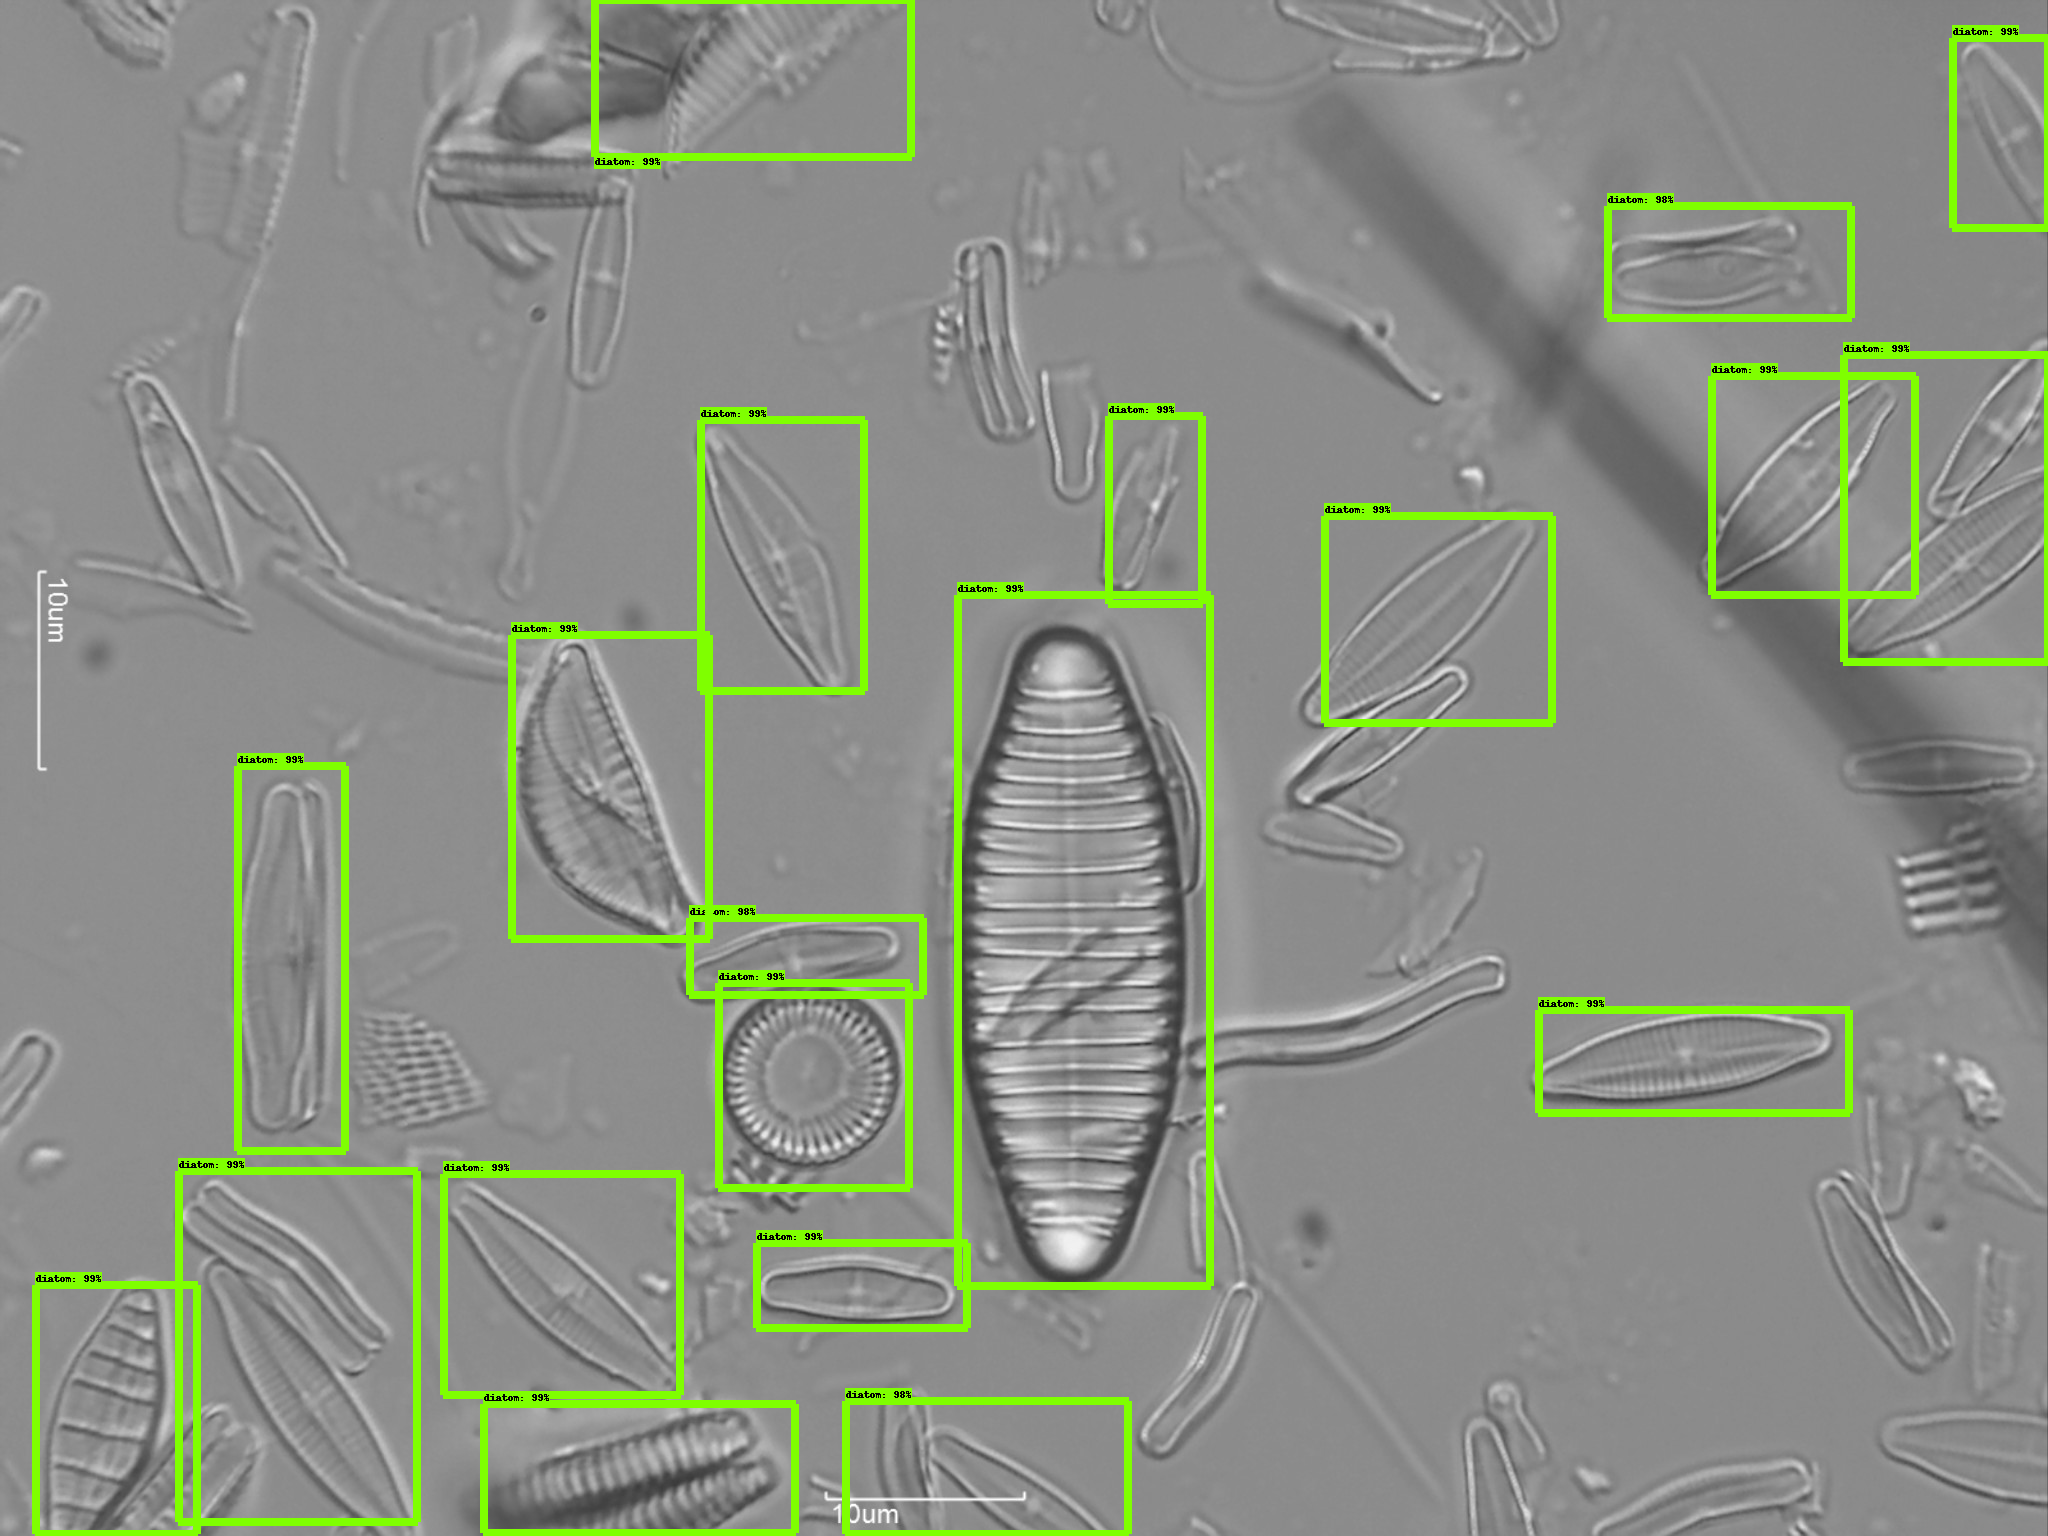

In [22]:
vis_util.visualize_boxes_and_labels_on_image_array(
      image,
      result['detection_boxes'],
      result['detection_classes'],
      result['detection_scores'],
      category_index,
      instance_masks=result.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

display(Image.fromarray(image))

In [27]:
import cv2
cv2.imwrite("yey.png", image)

True

In [ ]:
imutils.roate()